<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/04_training_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 선형 모델 훈련

선형 회귀 모델을 훈련하는 방법에는 크게 2가지가 있다.
- 직접 계산할 수 있는 공식을 사용해 훈련세트에 가장 잘맞는 모델을 __해석적__으로 구한다.
- __경사하강법(GD)__으로 모델 파라미터를 수정하여 훈련세트의 비용함수를 최소하하여 구한다.

## 선형 회귀

앞 장에서, RMSE(Root MSE)를 최소하하는 $\theta$를 찾았지만, MSE를 최소화 하는 $\theta$를 찾아도 결과과 같다. <br>
실제로 비용함수(Cost function)로 MSE를 사용해야 미분 특성상 계산이 단순하고, 규제(Regularization)적용이 가능하다.


### 정규 방정식

normal equation이라고 불리고, 식은 다음과 같다. <br>
$\boldsymbol{\hat{\theta}} = (\mathbf{X^{t}}\mathbf{X})^{-1}\mathbf{X^{t}}\mathbf{y}$ 

데이터를 무작위로 추출하여 정규방정식으로 계산 결과를 살펴보자

In [ ]:
# 데이터 생성
import numpy as np
X = 2* np.random.rand(100, 1) # 임의의 x를 추출하여
y = 4 + 3 * X + np.random.randn(100, 1) # noise 추가

In [ ]:
# summing vector 추가
X_b = np.c_[np.ones((100, 1)), X]
# theta 계산
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.08602319],
       [3.03030591]])

임의의 새로운 데이터 $\boldsymbol{x_{0}}=(0,2)^{t}$에 대한 $\hat{\mathbf{y}}_{0}$ 계산

In [ ]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.08602319],
       [10.14663501]])

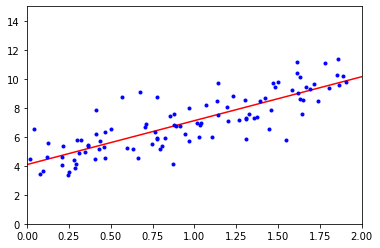

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

사이킷런에서 선형 회귀

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lin_reg.intercept_, lin_reg.coef_, lin_reg.predict(X_new)

(array([4.08602319]), array([[3.03030591]]), array([[ 4.08602319],
        [10.14663501]]))

- 사이킷런을 사용하지 않은 결과와 완전히 동일
<br>

특성(feature)의 수가 샘플보다 많거나 Linear dependent여서 $(\mathbf{X}^{t}\mathbf{X})^{-1}$를 구할 수 없는 경우, __일반화 역행렬(Generalized inverse)__을 이용한다. <br>
특히, 특이값 분해(Singular Value Decomposition)으로부터 나온 __Moor-Penrose Inverse__($\mathbf{X}^{+}$)을 이용한다. <br>
$\boldsymbol{\hat{\theta}} = \mathbf{X}^{+}\mathbf{y}$

In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.08602319],
       [3.03030591]])

- SVD로부터 $X=UDT^{t}$를 구한 후, D의 diagonal component가 rcond보다 작으면 0으로 바꾼 다음,  $X^{t}=TD^{+}U^{t}$를 구한다
<br>

numpy의 __np.linalg.pinv()__ 함수를 사용해도 Moor-Penrose inverse를 구할 수 있다.

In [ ]:
np.linalg.pinv(X_b).dot(y)

array([[4.08602319],
       [3.03030591]])

### 계산 복잡도

$n$을 특성(feature)의 수라 할때, $X^{t}X$의 역행렬 크기는 $(n+1)*(n+1)$이고, 정규방정식의 __계산 복잡도__(Computational complexity)는 일반적으로 $O(n^{2.4})$에서 $O(n^{3})$ 사이다. 즉, 특성의 수가 2배로 늘어나면 약 5.3~8배로 증가한다. <br>하지만 사이킷런의 __LinearRegression__ 클래스가 사용하는 SVD 방법은 계산 복잡도가 $O(n^{2})$이다. 특성의 수가 2배로 늘어나면 계산 시간은 4배가 된다. <br>
$m$을 샘플의 수라 할때, 정규방정식과 SVD 모두 $O(m)$으로, 샘플이 두배가 되면 계산 시간도 선형적으로 2배가 된다.

## 경사 하강법

해석적으로 최적의 해법을 찾을 수 없을 경우, 일반적인 최적의 해를 찾는 알고리즘이다. <br>
$\boldsymbol{\theta}$을 __무작위 초기화__(random initialization)시켜 비용함수(MSE 등)을 감소하는 방향으로 $\boldsymbol{\theta}$를 업데이트 시킨다. <br>
__학습률__(learning rate, $\eta$)은 하이퍼파라미터로 적절이 튜닝되야한다.

- 학습률이 작으면 수렴을 위해 반복이 많아지므로, 시간이 매우 오래 걸림.
- 학습률이 크면 해를 찾지 못하고 발산할 수 있음.
- 지역 최솟값(local minimum)에 빠질 수 있음.
- 안장점에서 학습 속도가 느려짐(맞나?)

다행히 선형회귀에서 MSE를 비용함수로 사용하면 __볼록 함수__(convex function)으로, 최솟값은 항상 전역 최솟값(global minimum)이 보장된다.

스케일링(scaling)도 경사하강법(GD)에선 중요한 문제다.


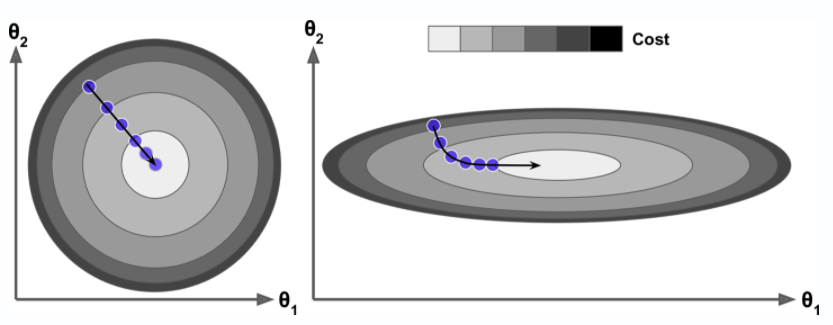

- 왼쪽의 경사하강법은 곧장 최적해로 진행되고 있지만, 스케일링이 되지 않은 오른쪽 그림은 최적해를 둘러서 진행하기 때문에 더 오랜 시간이 걸린다. 따라서 GD를 사용할 땐, 반드시 스케일링을 진행해야한다.
- 해석적인 방법(정규 방정식)으로 선형 회귀식을 구할 땐, scaling은 무시하여도 좋다.

### 배치 경사 하강법


배치 경사 하강법은 다음과 같은 스텝을 계속해서 반복한다.

$
\boldsymbol{\theta}_{(1)} = \boldsymbol{\theta}_{(0)} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta}) |_{\boldsymbol{\theta} = \boldsymbol{\theta}_{(0)}}
$


선형회귀이므로, 비용함수 MSE의 partial derivative는 다음과 같다.

$
\dfrac{\partial}{\partial \theta_{j}} \text{MSE}(\boldsymbol{\theta}) = \dfrac{2}{m}\sum_{i=1}^m(\boldsymbol{\theta}^{t}\mathbf{x}^{(i)} - \mathbf{y})x^{(i)}_{j}
$

vector notation으로 나타내면 다음과 같다.

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$


코드로 구현해보자.

In [ ]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

theta

array([[4.08602319],
       [3.03030591]])

- 정규 방정식의 결과와 동일하다.
- 매 스텝에서 훈련 데이터 전체를 사용한다.
- 따라서, 훈련 데이터가 크면 느리다.

학습률$\eta$에 따른, 경사 하강법의 스텝을 살펴보자

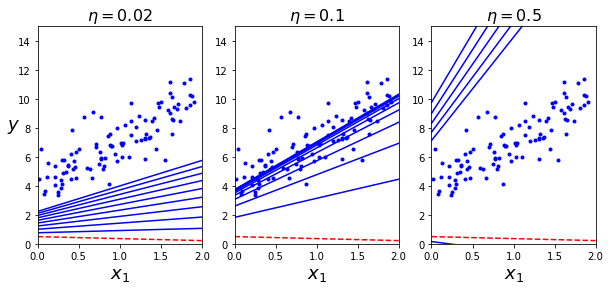

In [ ]:
theta_path_bgd = [] # 나중에 배치, 확률, 미니배치 비교를 위해

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

- $\eta=0.02$이면, 수렴속도가 느리다.
- $\eta=0.5$이면, 수렴하지 못하고 발산한다.
- 즉, $\eta$는 하이퍼파리미터로 튜닝과정을 거쳐야한다.

### 확률적 경사 하강법

배치 경사 하강법에서는 매 스텝마다 전체 훈련 세트를 사용하기 때문에, 훈련세트가 많아지면 속도가 느려지는 단점을 가지고 있다. <br>
반면에 __확률적 경사 하강법__(Stocahstic GD)은 매 스텝마다 한개의 훈련 세트를 사용하기 때문에 비교적 큰 훈련세트에서 속도가 빠르다. <br>
확률적 경사 하강법은 확률적이므로 배치 경사 하강법 보다 훨씬 불안정하다. <br>
실제로 배치 경사 하강법은 스텝이 증가하면 최적해에 가까워지지만, 확률적 경사 하강법은 확률적으로 최적해에서 멀어질 수 있다. 또한 최적해 근처에서 맴도는 문제가 생긴다.(즉, 스텝이 증가하면 학습률을 줄여줘야함!) <br>
스텝이 샘플 수 m 만큼 진행되면 이를 1 __에포크__(epoch)라고 한다

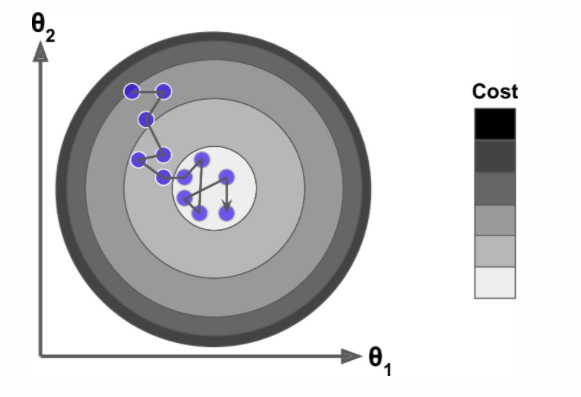

코드로 구현해보자.

In [ ]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

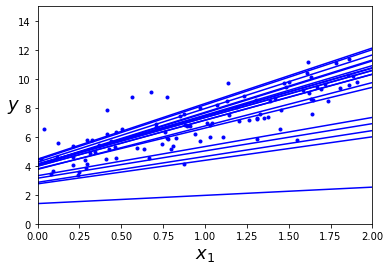

In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # 첫 에포그의 20개 직선만 그림
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)          # m개 샘플 색인을 랜덤하게 1개 뽑음 
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) # 샘플이 1개이므로 m이 빠짐
        eta = learning_schedule(epoch * m + i)       # 스텝(혹은 에포크)가 증가하면 학습률을 줄여줌
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # 책에는 없음

plt.plot(X, y, "b.")                                 # 책에는 없음
plt.xlabel("$x_1$", fontsize=18)                     # 책에는 없음
plt.ylabel("$y$", rotation=0, fontsize=18)           # 책에는 없음
plt.axis([0, 2, 0, 15])                              # 책에는 없음
plt.show()           

In [ ]:
theta

array([[4.13816229],
       [3.04105396]])

- 배치 경사하강법과 거의 유사하나 약간 다름

사이킷런의 __SGDRegressor__ 클래스를 사용해 확률적 경사 하강법 구현

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel()) # ravel은 다차원을 1차원으로 바꿈

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

- max_iter=1000 : 1000번의 에포크
- tol=1e-3 : 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행
- eta0=0.1 : 학습률 0.1(최적해에 수렴할 수 있도록, 학습률을 점점 줄여나감)

### 미니배치 경사 하강법

전체 훈련 세트를 임의의 작은 샘플 세트인 __미니배치__ 에 대해 GD를 계산하는 방법을 __미니배치 경사 하강법__이라 부른다. <br>
행렬 연산에 최적화된 하드웨어(GPU 등)를 사용하면 확률적 경사 하강법에 비해 미니배치 경사 하강법은 높은 성능을 보인다.

In [ ]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [ ]:
theta

array([[4.23241176],
       [3.2000992 ]])

In [ ]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

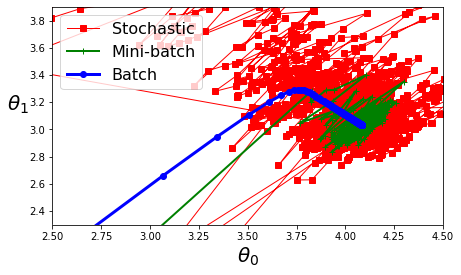

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

요약하자면, <br>

|알고리즘 |m이 클 때 | 외부 메모리 학습 지원 | n이 클 때| Hyper parameter | 스케일링 필요 | 사이킷런|
|---|---|---|---|---|---|---|
|정규방정식|빠름|No|느림|0| No| N/A|
|정규방정식|빠름|No|느림|0| No| LinearRegression|
|정규방정식|느림|No|빠름|0| Yes| SGDRegressor|
|정규방정식|빠름|Yes|빠름|>=2| Yes| SGDRegressor|
|정규방정식|빠름|Yes|빠름|>=2| Yes| SGDRegressor|